### Save final predictions in required format

In [ ]:
#!pip install -U --pre segmentation-models --user 

In [1]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
#import skimage.draw
from skimage import io
import random
import keras
import cv2
from glob import glob
import warnings
import random
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import resize
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

# Helper for dirtectory creation
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
# Name experiment
experiment_name = "exp-1"
        
    
# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Model path
log_path = os.path.join(ROOT_DIR, "logs", experiment_name)

# Test file directory
IMAGES_FOLDER = os.path.join(ROOT_DIR, "dataset", "Testing images/")

# Target destination for storing the prediction masks
PRED_DEST =  os.path.join(ROOT_DIR, "dataset", "the_great_backpropagator_MoNuSAC_test_results")

# Create folder prediction parent folder
create_directory(PRED_DEST)

Using TensorFlow backend.


### Load the model

In [2]:
model = None
model = load_model('{}/{}.h5'.format(log_path, experiment_name), compile=False)
#model.summary()

## Helper functions

In [3]:
def pad(img, pad_size=96):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 96 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)



def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]



def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)

    
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


def extract_patches(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + patch_size[0], x:x + patch_size[0]]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H
        #print(raw_dim)
        #print(patch.shape)


        if raw_dim != (patch_size[0], patch_size[1]):

            # Resize to 64x64
            #patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
            patch, pad_locs = pad(patch, pad_size=patch_size[0])
            
            
            # Do stuffffff
            patches.append(patch)
        
        else:

            # Do stuffffff
            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches
    
    
    
    
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

In [4]:
import numpy as np
from skimage.transform import resize

# Helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(18, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
    
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img




def visualize_results(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)


    
def vis_gray(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')



def predict(im):
    """Predict on patch"""
    
    im = np.expand_dims(im, axis=0)
    
    im = model.predict(im)
    im = np.argmax(im.squeeze(), axis=-1)
 
    #assert im.shape == (96, 96), "Wrong shape, {}!".format(im.shape)
    
    return im



def whole_slide_predict(whole_image):
    
    #import pdb; pdb.set_trace()
    
    # If input image less than patch, infer on whole image
    if whole_image.shape[0] < 96 or whole_image.shape[1] < 96:
        
        # Get size
        raw_dim = (whole_image.shape[1], whole_image.shape[0]) # W, H
        
        # Resize to 64x64 for prediction
        #whole_image_rs = cv2.resize(whole_image, (64, 64), interpolation = cv2.INTER_AREA)
        whole_image_rs, pad_locs = pad(whole_image, pad_size=96)
        
        
        # Infer
        pred = predict(whole_image_rs)
        
        
        # Resize back to original shape
        #pred = cv2.resize(pred, raw_dim, interpolation = cv2.INTER_AREA)
        pred = unpad(pred, pad_locs)
        
        # Change dtype for resizing back to original shape
        pred = pred.astype(np.uint8)
        
      
    else:
        
        # Get patch locations
        x_pos, y_pos, cells = sliding_window(whole_image, 96, (96, 96)) 

        # Array for storing predictions
        pred = np.zeros((whole_image.shape[0], whole_image.shape[1])).astype(np.uint8)

        # Slide over each patch
        for (x, y, cell) in zip(x_pos, y_pos, cells):

            # Get patch
            patch = whole_image[y:y + 96, x:x + 96]

            # Get size
            raw_dim = (patch.shape[1], patch.shape[0]) # W, H

            # If less than patch size, resize and then run prediction
            if raw_dim != (96, 96):


                # Resize to 64x64
                #patch_rs = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
                patch_rs, pad_locs = pad(patch, pad_size=96)
                
                #print(patch.dtype, processed.dtype)
                
                assert patch.dtype == patch_rs.dtype, "Wrong data type after resizing!"

                
                # Infer
                processed = predict(patch_rs)
                
                # Resize back to original shape
                #processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
                processed = unpad(processed, pad_locs)
                
                # Change dtype 
                processed = processed.astype(np.uint8)
                
                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"

            else:

                
                # Infer
                processed = predict(patch)
                
                # Change dtype
                processed = processed.astype(np.uint8)

                #print(patch.dtype, processed.dtype)
                

                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"


            # Add in image variable
            pred[y:y + 96, x:x + 96] = processed 
            processed = None

    return pred


### Save predcition in required format

In [5]:
# label_map = {'Epithelial':1, 'Lymphocyte':2, 'Macrophage':4, 'Neutrophil':3, }

# Read patient folders
IMAGES_SUB_FOLDER = [os.path.join(IMAGES_FOLDER, i) for i in sorted(next(os.walk(IMAGES_FOLDER))[1])]


# Test image path
image_paths = []

# Iterate over patient folders
raw_ct = 0
for ct in tqdm(range(len(IMAGES_SUB_FOLDER[:]))):
    
    #print(ct)
    
    # Read all raw images in patient sub folder
    all_imgs = sorted(glob(IMAGES_SUB_FOLDER[ct] + '/*.tif'))
    
    # Get patient ID
    #pn = IMAGES_SUB_FOLDER[ct].split('.')[0][-23:]
    pn = IMAGES_SUB_FOLDER[ct].split('/')[-1]
    
    print("Patient ID ----------------------> : ", pn)
    
    # Create patient folder with ID
    pn_folder = os.path.join(PRED_DEST, pn)
    create_directory(pn_folder)
    
    # Get all images in the patient folder
    paths = [s.split('/')[-1][:-4] for s in all_imgs]
    
    print(paths)
    
    
    
    # Iterate over the images of a patient
    for i in range(len(all_imgs)):
        
        # Read patient image
        image_paths.append(all_imgs[i])
        img = read_nuclei(all_imgs[i])
        
        print("Patient image: ", paths[i])
        
        # Create sub folder -> each sub image for a patient
        patient_sub_folder = os.path.join(pn_folder, paths[i])
        create_directory(patient_sub_folder)
        
        # For each sub folder(sub image) make sub-sub folder for each cell type
        epi_path = os.path.join(patient_sub_folder, "Epithelial")
        lym_path = os.path.join(patient_sub_folder, "Lymphocyte")
        neu_path = os.path.join(patient_sub_folder, "Neutrophil")
        macro_path = os.path.join(patient_sub_folder, "Macrophage")
        
        # Creat sub-sub folders for each sub image
        create_directory(epi_path)
        create_directory(lym_path)
        create_directory(neu_path)
        create_directory(macro_path)
        
        
        # Predict whole slide sub image of a patient
        pred = whole_slide_predict(img)
        
        # Post processing to refine predictions
        pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

        #print(img.shape, pred.shape)
        #print("Uniques predicted", np.unique(pred_filt))

        # Make dummy mask
        zero_mask = np.zeros((pred_filt.shape[0], pred_filt.shape[1])).astype(np.uint8)

        # Overlay target class outputs
        epi_mask = np.where(pred_filt != 1, zero_mask, 1)
        lym_mask = np.where(pred_filt != 2, zero_mask, 2)
        neu_mask = np.where(pred_filt != 3, zero_mask, 3)
        macro_mask = np.where(pred_filt != 4, zero_mask, 4)
        
        # Save masks
        # Check if last number of uniques is not zero, if it is not then save this mask.
        # If it zero, it means the mask is empty, so skip this
        if np.unique(epi_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(epi_path, raw_ct), epi_mask)
                sio.savemat("{}/{}.mat".format(epi_path, raw_ct), {'epi_mask':epi_mask})
        
        raw_ct+=1

        if np.unique(lym_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(lym_path, raw_ct), lym_mask)
                sio.savemat("{}/{}.mat".format(lym_path, raw_ct), {'lym_mask':lym_mask})
                
        raw_ct+=1
        
        if np.unique(neu_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(neu_path, raw_ct), neu_mask)
                sio.savemat("{}/{}.mat".format(neu_path, raw_ct), {'neu_mask':neu_mask})
                
        raw_ct+=1
        
        if np.unique(macro_mask)[-1] != 0:
                #np.save("{}/{}.npy".format(macro_path, raw_ct), macro_mask)
                sio.savemat("{}/{}.mat".format(macro_path, raw_ct), {'macro_mask':macro_mask})
                
        raw_ct+=1
    

  0%|          | 0/25 [00:00<?, ?it/s]

Patient ID ----------------------> :  TCGA-2Z-A9JG-01Z-00-DX1
['TCGA-2Z-A9JG-01Z-00-DX1_1', 'TCGA-2Z-A9JG-01Z-00-DX1_2', 'TCGA-2Z-A9JG-01Z-00-DX1_3', 'TCGA-2Z-A9JG-01Z-00-DX1_4', 'TCGA-2Z-A9JG-01Z-00-DX1_5', 'TCGA-2Z-A9JG-01Z-00-DX1_6']
Patient image:  TCGA-2Z-A9JG-01Z-00-DX1_1
Patient image:  TCGA-2Z-A9JG-01Z-00-DX1_2
Patient image:  TCGA-2Z-A9JG-01Z-00-DX1_3
Patient image:  TCGA-2Z-A9JG-01Z-00-DX1_4
Patient image:  TCGA-2Z-A9JG-01Z-00-DX1_5
Patient image:  TCGA-2Z-A9JG-01Z-00-DX1_6


  4%|▍         | 1/25 [00:08<03:17,  8.25s/it]

Patient ID ----------------------> :  TCGA-2Z-A9JN-01Z-00-DX1
['TCGA-2Z-A9JN-01Z-00-DX1_1', 'TCGA-2Z-A9JN-01Z-00-DX1_2', 'TCGA-2Z-A9JN-01Z-00-DX1_3', 'TCGA-2Z-A9JN-01Z-00-DX1_4']
Patient image:  TCGA-2Z-A9JN-01Z-00-DX1_1
Patient image:  TCGA-2Z-A9JN-01Z-00-DX1_2
Patient image:  TCGA-2Z-A9JN-01Z-00-DX1_3
Patient image:  TCGA-2Z-A9JN-01Z-00-DX1_4


  8%|▊         | 2/25 [00:20<03:38,  9.52s/it]

Patient ID ----------------------> :  TCGA-49-6743-01Z-00-DX2
['TCGA-49-6743-01Z-00-DX2_001', 'TCGA-49-6743-01Z-00-DX2_002', 'TCGA-49-6743-01Z-00-DX2_003', 'TCGA-49-6743-01Z-00-DX2_004', 'TCGA-49-6743-01Z-00-DX2_005']
Patient image:  TCGA-49-6743-01Z-00-DX2_001
Patient image:  TCGA-49-6743-01Z-00-DX2_002
Patient image:  TCGA-49-6743-01Z-00-DX2_003
Patient image:  TCGA-49-6743-01Z-00-DX2_004
Patient image:  TCGA-49-6743-01Z-00-DX2_005


 12%|█▏        | 3/25 [00:33<03:48, 10.41s/it]

Patient ID ----------------------> :  TCGA-50-6591-01Z-00-DX1
['TCGA-50-6591-01Z-00-DX1_001']
Patient image:  TCGA-50-6591-01Z-00-DX1_001


 16%|█▌        | 4/25 [00:36<02:55,  8.35s/it]

Patient ID ----------------------> :  TCGA-55-7570-01Z-00-DX1
['TCGA-55-7570-01Z-00-DX1_001', 'TCGA-55-7570-01Z-00-DX1_002']
Patient image:  TCGA-55-7570-01Z-00-DX1_001


 20%|██        | 5/25 [00:38<02:05,  6.26s/it]

Patient image:  TCGA-55-7570-01Z-00-DX1_002
Patient ID ----------------------> :  TCGA-55-7573-01Z-00-DX1
['TCGA-55-7573-01Z-00-DX1_001', 'TCGA-55-7573-01Z-00-DX1_002', 'TCGA-55-7573-01Z-00-DX1_003', 'TCGA-55-7573-01Z-00-DX1_004']
Patient image:  TCGA-55-7573-01Z-00-DX1_001
Patient image:  TCGA-55-7573-01Z-00-DX1_002
Patient image:  TCGA-55-7573-01Z-00-DX1_003
Patient image:  TCGA-55-7573-01Z-00-DX1_004


 24%|██▍       | 6/25 [00:46<02:09,  6.79s/it]

Patient ID ----------------------> :  TCGA-73-4662-01Z-00-DX1
['TCGA-73-4662-01Z-00-DX1_001', 'TCGA-73-4662-01Z-00-DX1_002', 'TCGA-73-4662-01Z-00-DX1_003']
Patient image:  TCGA-73-4662-01Z-00-DX1_001
Patient image:  TCGA-73-4662-01Z-00-DX1_002
Patient image:  TCGA-73-4662-01Z-00-DX1_003


 28%|██▊       | 7/25 [00:53<02:06,  7.04s/it]

Patient ID ----------------------> :  TCGA-78-7152-01Z-00-DX1
['TCGA-78-7152-01Z-00-DX1_001', 'TCGA-78-7152-01Z-00-DX1_002']
Patient image:  TCGA-78-7152-01Z-00-DX1_001


 32%|███▏      | 8/25 [00:54<01:27,  5.14s/it]

Patient image:  TCGA-78-7152-01Z-00-DX1_002
Patient ID ----------------------> :  TCGA-A2-A04X-01Z-00-DX1
['TCGA-A2-A04X-01Z-00-DX1_001', 'TCGA-A2-A04X-01Z-00-DX1_002', 'TCGA-A2-A04X-01Z-00-DX1_003', 'TCGA-A2-A04X-01Z-00-DX1_004']
Patient image:  TCGA-A2-A04X-01Z-00-DX1_001
Patient image:  TCGA-A2-A04X-01Z-00-DX1_002
Patient image:  TCGA-A2-A04X-01Z-00-DX1_003
Patient image:  TCGA-A2-A04X-01Z-00-DX1_004


 36%|███▌      | 9/25 [01:01<01:31,  5.73s/it]

Patient ID ----------------------> :  TCGA-A2-A0ES-01Z-00-DX1
['TCGA-A2-A0ES-01Z-00-DX1_001', 'TCGA-A2-A0ES-01Z-00-DX1_002', 'TCGA-A2-A0ES-01Z-00-DX1_003', 'TCGA-A2-A0ES-01Z-00-DX1_004']
Patient image:  TCGA-A2-A0ES-01Z-00-DX1_001
Patient image:  TCGA-A2-A0ES-01Z-00-DX1_002
Patient image:  TCGA-A2-A0ES-01Z-00-DX1_003
Patient image:  TCGA-A2-A0ES-01Z-00-DX1_004


 40%|████      | 10/25 [01:06<01:20,  5.34s/it]

Patient ID ----------------------> :  TCGA-D8-A3Z6-01Z-00-DX2
['TCGA-D8-A3Z6-01Z-00-DX2_001', 'TCGA-D8-A3Z6-01Z-00-DX2_002', 'TCGA-D8-A3Z6-01Z-00-DX2_003', 'TCGA-D8-A3Z6-01Z-00-DX2_004']
Patient image:  TCGA-D8-A3Z6-01Z-00-DX2_001
Patient image:  TCGA-D8-A3Z6-01Z-00-DX2_002
Patient image:  TCGA-D8-A3Z6-01Z-00-DX2_003
Patient image:  TCGA-D8-A3Z6-01Z-00-DX2_004


 44%|████▍     | 11/25 [01:11<01:17,  5.50s/it]

Patient ID ----------------------> :  TCGA-DW-7838-01Z-00-DX1
['TCGA-DW-7838-01Z-00-DX1_1', 'TCGA-DW-7838-01Z-00-DX1_2', 'TCGA-DW-7838-01Z-00-DX1_3', 'TCGA-DW-7838-01Z-00-DX1_4', 'TCGA-DW-7838-01Z-00-DX1_5']
Patient image:  TCGA-DW-7838-01Z-00-DX1_1
Patient image:  TCGA-DW-7838-01Z-00-DX1_2
Patient image:  TCGA-DW-7838-01Z-00-DX1_3
Patient image:  TCGA-DW-7838-01Z-00-DX1_4
Patient image:  TCGA-DW-7838-01Z-00-DX1_5


 48%|████▊     | 12/25 [01:16<01:08,  5.29s/it]

Patient ID ----------------------> :  TCGA-DW-7963-01Z-00-DX1
['TCGA-DW-7963-01Z-00-DX1_1', 'TCGA-DW-7963-01Z-00-DX1_2', 'TCGA-DW-7963-01Z-00-DX1_3', 'TCGA-DW-7963-01Z-00-DX1_4', 'TCGA-DW-7963-01Z-00-DX1_5']
Patient image:  TCGA-DW-7963-01Z-00-DX1_1
Patient image:  TCGA-DW-7963-01Z-00-DX1_2
Patient image:  TCGA-DW-7963-01Z-00-DX1_3
Patient image:  TCGA-DW-7963-01Z-00-DX1_4
Patient image:  TCGA-DW-7963-01Z-00-DX1_5


 52%|█████▏    | 13/25 [01:18<00:51,  4.26s/it]

Patient ID ----------------------> :  TCGA-E2-A108-01Z-00-DX1
['TCGA-E2-A108-01Z-00-DX1_001', 'TCGA-E2-A108-01Z-00-DX1_002', 'TCGA-E2-A108-01Z-00-DX1_003', 'TCGA-E2-A108-01Z-00-DX1_004', 'TCGA-E2-A108-01Z-00-DX1_005']
Patient image:  TCGA-E2-A108-01Z-00-DX1_001
Patient image:  TCGA-E2-A108-01Z-00-DX1_002
Patient image:  TCGA-E2-A108-01Z-00-DX1_003
Patient image:  TCGA-E2-A108-01Z-00-DX1_004
Patient image:  TCGA-E2-A108-01Z-00-DX1_005


 56%|█████▌    | 14/25 [01:24<00:53,  4.83s/it]

Patient ID ----------------------> :  TCGA-EW-A6SB-01Z-00-DX1
['TCGA-EW-A6SB-01Z-00-DX1_001', 'TCGA-EW-A6SB-01Z-00-DX1_002', 'TCGA-EW-A6SB-01Z-00-DX1_003', 'TCGA-EW-A6SB-01Z-00-DX1_004', 'TCGA-EW-A6SB-01Z-00-DX1_005']
Patient image:  TCGA-EW-A6SB-01Z-00-DX1_001
Patient image:  TCGA-EW-A6SB-01Z-00-DX1_002
Patient image:  TCGA-EW-A6SB-01Z-00-DX1_003
Patient image:  TCGA-EW-A6SB-01Z-00-DX1_004
Patient image:  TCGA-EW-A6SB-01Z-00-DX1_005


 60%|██████    | 15/25 [01:27<00:43,  4.31s/it]

Patient ID ----------------------> :  TCGA-F9-A8NY-01Z-00-DX1
['TCGA-F9-A8NY-01Z-00-DX1_1', 'TCGA-F9-A8NY-01Z-00-DX1_2', 'TCGA-F9-A8NY-01Z-00-DX1_3', 'TCGA-F9-A8NY-01Z-00-DX1_4']
Patient image:  TCGA-F9-A8NY-01Z-00-DX1_1
Patient image:  TCGA-F9-A8NY-01Z-00-DX1_2
Patient image:  TCGA-F9-A8NY-01Z-00-DX1_3


 64%|██████▍   | 16/25 [01:39<00:59,  6.57s/it]

Patient image:  TCGA-F9-A8NY-01Z-00-DX1_4
Patient ID ----------------------> :  TCGA-G9-6356-01Z-00-DX1
['TCGA-G9-6356-01Z-00-DX1_1', 'TCGA-G9-6356-01Z-00-DX1_3', 'TCGA-G9-6356-01Z-00-DX1_4', 'TCGA-G9-6356-01Z-00-DX1_5', 'TCGA-G9-6356-01Z-00-DX1_6']
Patient image:  TCGA-G9-6356-01Z-00-DX1_1
Patient image:  TCGA-G9-6356-01Z-00-DX1_3
Patient image:  TCGA-G9-6356-01Z-00-DX1_4
Patient image:  TCGA-G9-6356-01Z-00-DX1_5
Patient image:  TCGA-G9-6356-01Z-00-DX1_6


 68%|██████▊   | 17/25 [01:46<00:53,  6.66s/it]

Patient ID ----------------------> :  TCGA-G9-6367-01Z-00-DX1
['TCGA-G9-6367-01Z-00-DX1_1', 'TCGA-G9-6367-01Z-00-DX1_2', 'TCGA-G9-6367-01Z-00-DX1_3', 'TCGA-G9-6367-01Z-00-DX1_4', 'TCGA-G9-6367-01Z-00-DX1_5', 'TCGA-G9-6367-01Z-00-DX1_6', 'TCGA-G9-6367-01Z-00-DX1_7']
Patient image:  TCGA-G9-6367-01Z-00-DX1_1
Patient image:  TCGA-G9-6367-01Z-00-DX1_2
Patient image:  TCGA-G9-6367-01Z-00-DX1_3
Patient image:  TCGA-G9-6367-01Z-00-DX1_4
Patient image:  TCGA-G9-6367-01Z-00-DX1_5
Patient image:  TCGA-G9-6367-01Z-00-DX1_6
Patient image:  TCGA-G9-6367-01Z-00-DX1_7


 72%|███████▏  | 18/25 [01:54<00:49,  7.14s/it]

Patient ID ----------------------> :  TCGA-IZ-A6M9-01Z-00-DX1
['TCGA-IZ-A6M9-01Z-00-DX1_1', 'TCGA-IZ-A6M9-01Z-00-DX1_2', 'TCGA-IZ-A6M9-01Z-00-DX1_3']
Patient image:  TCGA-IZ-A6M9-01Z-00-DX1_1
Patient image:  TCGA-IZ-A6M9-01Z-00-DX1_2
Patient image:  TCGA-IZ-A6M9-01Z-00-DX1_3


 76%|███████▌  | 19/25 [02:03<00:45,  7.55s/it]

Patient ID ----------------------> :  TCGA-MH-A55W-01Z-00-DX1
['TCGA-MH-A55W-01Z-00-DX1_1', 'TCGA-MH-A55W-01Z-00-DX1_2', 'TCGA-MH-A55W-01Z-00-DX1_3', 'TCGA-MH-A55W-01Z-00-DX1_4']
Patient image:  TCGA-MH-A55W-01Z-00-DX1_1
Patient image:  TCGA-MH-A55W-01Z-00-DX1_2
Patient image:  TCGA-MH-A55W-01Z-00-DX1_3
Patient image:  TCGA-MH-A55W-01Z-00-DX1_4


 80%|████████  | 20/25 [02:03<00:26,  5.35s/it]

Patient ID ----------------------> :  TCGA-MP-A4T7-01Z-00-DX1
['TCGA-MP-A4T7-01Z-00-DX1_001', 'TCGA-MP-A4T7-01Z-00-DX1_002', 'TCGA-MP-A4T7-01Z-00-DX1_003', 'TCGA-MP-A4T7-01Z-00-DX1_004', 'TCGA-MP-A4T7-01Z-00-DX1_005']
Patient image:  TCGA-MP-A4T7-01Z-00-DX1_001
Patient image:  TCGA-MP-A4T7-01Z-00-DX1_002
Patient image:  TCGA-MP-A4T7-01Z-00-DX1_003
Patient image:  TCGA-MP-A4T7-01Z-00-DX1_004
Patient image:  TCGA-MP-A4T7-01Z-00-DX1_005


 84%|████████▍ | 21/25 [02:08<00:20,  5.23s/it]

Patient ID ----------------------> :  TCGA-VP-A87E-01Z-00-DX1
['TCGA-VP-A87E-01Z-00-DX1_1', 'TCGA-VP-A87E-01Z-00-DX1_2', 'TCGA-VP-A87E-01Z-00-DX1_3', 'TCGA-VP-A87E-01Z-00-DX1_4', 'TCGA-VP-A87E-01Z-00-DX1_5']
Patient image:  TCGA-VP-A87E-01Z-00-DX1_1
Patient image:  TCGA-VP-A87E-01Z-00-DX1_2
Patient image:  TCGA-VP-A87E-01Z-00-DX1_3
Patient image:  TCGA-VP-A87E-01Z-00-DX1_4
Patient image:  TCGA-VP-A87E-01Z-00-DX1_5


 88%|████████▊ | 22/25 [02:18<00:20,  6.70s/it]

Patient ID ----------------------> :  TCGA-VP-A87H-01Z-00-DX1
['TCGA-VP-A87H-01Z-00-DX1_1', 'TCGA-VP-A87H-01Z-00-DX1_2', 'TCGA-VP-A87H-01Z-00-DX1_5', 'TCGA-VP-A87H-01Z-00-DX1_6']
Patient image:  TCGA-VP-A87H-01Z-00-DX1_1
Patient image:  TCGA-VP-A87H-01Z-00-DX1_2
Patient image:  TCGA-VP-A87H-01Z-00-DX1_5
Patient image:  TCGA-VP-A87H-01Z-00-DX1_6


 92%|█████████▏| 23/25 [02:27<00:14,  7.33s/it]

Patient ID ----------------------> :  TCGA-X4-A8KS-01Z-00-DX3
['TCGA-X4-A8KS-01Z-00-DX3_1']
Patient image:  TCGA-X4-A8KS-01Z-00-DX3_1


 96%|█████████▌| 24/25 [02:29<00:05,  5.66s/it]

Patient ID ----------------------> :  TCGA-YL-A9WL-01Z-00-DX1
['TCGA-YL-A9WL-01Z-00-DX1_1', 'TCGA-YL-A9WL-01Z-00-DX1_2', 'TCGA-YL-A9WL-01Z-00-DX1_3', 'TCGA-YL-A9WL-01Z-00-DX1_4']
Patient image:  TCGA-YL-A9WL-01Z-00-DX1_1
Patient image:  TCGA-YL-A9WL-01Z-00-DX1_2
Patient image:  TCGA-YL-A9WL-01Z-00-DX1_3
Patient image:  TCGA-YL-A9WL-01Z-00-DX1_4


100%|██████████| 25/25 [02:32<00:00,  6.09s/it]


### Run inference on a random single image for visualization purposes 

Index:  16
Image shape: (446, 512, 3)
uint8
(446, 512, 3) (446, 512)
Uniques predicted [0 1 2]
(446, 512) (446, 512) (446, 512) (446, 512)
Epi mask uniques predicted [0 1]
Lym mask uniques predicted [0 2]
Neu mask uniques predicted [0]
Macro mask uniques predicted [0]


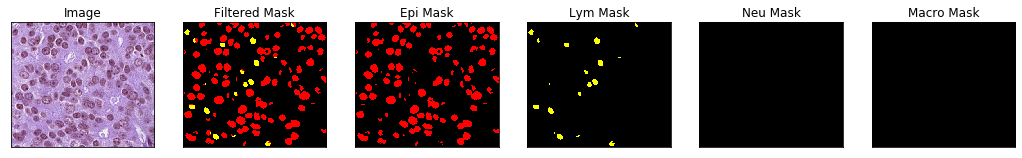

In [7]:
idx = random.randrange(len(image_paths))
print("Index: ",idx)

# Read image
image = read_nuclei(image_paths[-1])
print("Image shape:", image.shape)

# Predict
pred = whole_slide_predict(image)
print(pred.dtype)

# Post processing to refine predictions
pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

print(image.shape, pred.shape)
print("Uniques predicted", np.unique(pred))

# Dummy mask
zero_mask = np.zeros((pred_filt.shape[0], pred_filt.shape[1])).astype(np.uint8)
# Overlay target class
epi_mask = np.where(pred_filt != 1, zero_mask, 1)
lym_mask = np.where(pred_filt != 2, zero_mask, 2)
neu_mask = np.where(pred_filt != 3, zero_mask, 3)
macro_mask = np.where(pred_filt != 4, zero_mask, 4)

# Get uniques for (debugging)
print(epi_mask.shape, lym_mask.shape, neu_mask.shape, macro_mask.shape)
print("Epi mask uniques predicted", np.unique(epi_mask))
print("Lym mask uniques predicted", np.unique(lym_mask))
print("Neu mask uniques predicted", np.unique(neu_mask))
print("Macro mask uniques predicted", np.unique(macro_mask))
      
visualize(
        image=image,
        Filtered_mask = pred_filt,
        Epi_mask = epi_mask,
        Lym_mask = lym_mask,
        Neu_mask = neu_mask,
        Macro_mask = macro_mask)

In [ ]:
print("Done!")